In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.future import manual_lasso_segmentation
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("\n🔹 Train Data info before conversion:")
print(train_df.info())

# Show a well-formatted preview of the DataFrame
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)  # You can increase if needed
pd.set_option("display.width", None)

print("\n🔹 Train Data Step 0:")
train_df.head(10)  # Show first 10 rows


🔹 Train Data info before conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

🔹 Train Data Step 0:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [ ]:
base_categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
extra_categoricals = ['Group', 'GroupNum', 'Deck', 'Side']
categorical_cols = base_categorical_cols + extra_categoricals

def engineer_features(df):
    df = df.copy()
    df[['Group', 'GroupNum']] = df['PassengerId'].str.split('_', expand=True)
    df[['Deck', 'CabinNumber', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Deck'] = df['Deck'].astype('category')
    df['CabinNumber'] = pd.to_numeric(df['CabinNumber'], errors='coerce')
    df['Side'] = df['Side'].astype('category')

    for col in base_categorical_cols:
        df[col] = df[col].astype('category')

    df.drop(columns=['Cabin', 'Name'], inplace=True, errors='ignore')
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

combined = pd.concat([train_df, test_df], sort=False)
combined['Group'] = combined['PassengerId'].str.split('_').str[0]
combined['GroupSize'] = combined.groupby('Group')['PassengerId'].transform('count')

train_df['GroupSize'] = combined.iloc[:len(train_df)]['GroupSize'].values
test_df['GroupSize'] = combined.iloc[len(train_df):]['GroupSize'].values

train_df.drop(columns=['Group', 'GroupNum'], inplace=True)
test_df.drop(columns=['Group', 'GroupNum'], inplace=True)

print("\n🔹 Train Data Step 1:")
train_df.head(10)


🔹 Train Data Step 1:


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side,GroupSize
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S,1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S,2
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S,2
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S,1
5,0005_01,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,F,0.0,P,1
6,0006_01,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,F,2.0,S,2
7,0006_02,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,G,0.0,S,2
8,0007_01,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,F,3.0,S,1
9,0008_01,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,B,1.0,P,3



🔹 Correlation heatmap (numerical columns):


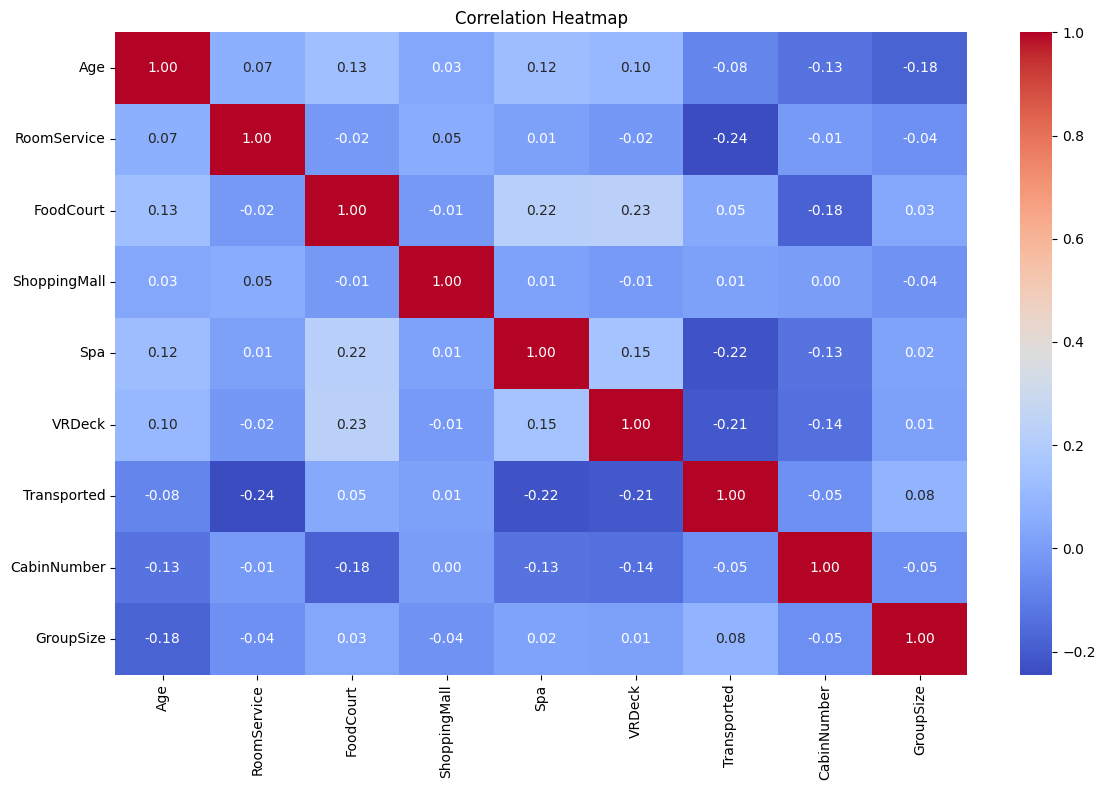

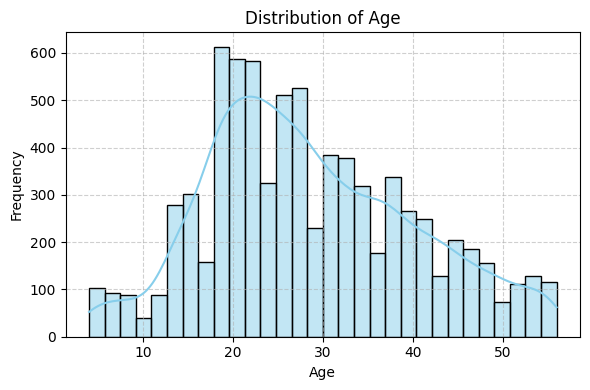

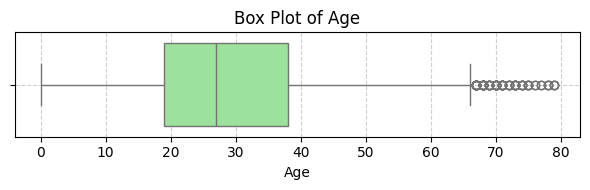

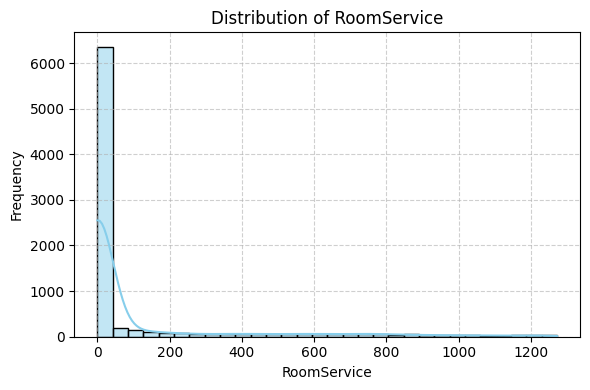

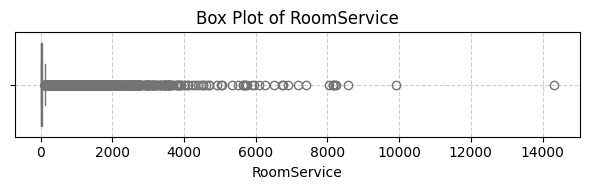

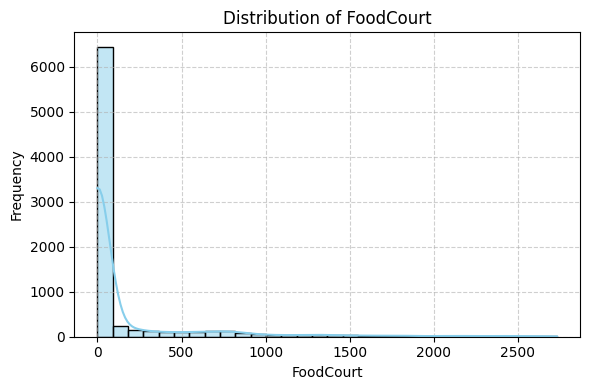

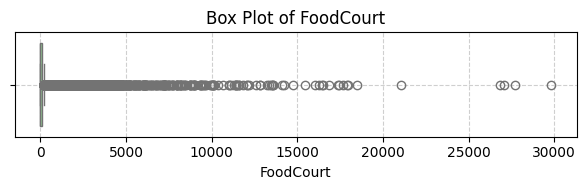

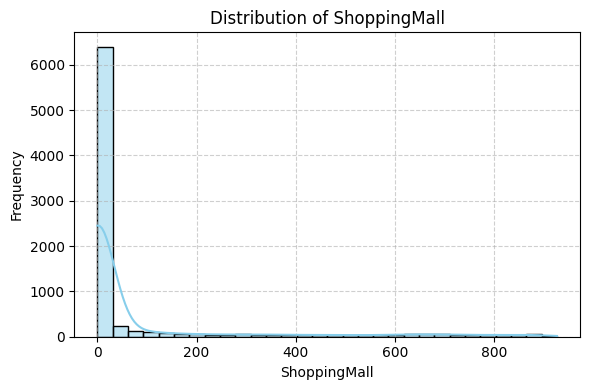

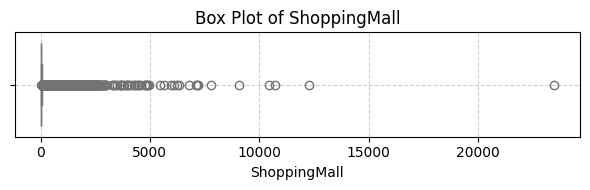

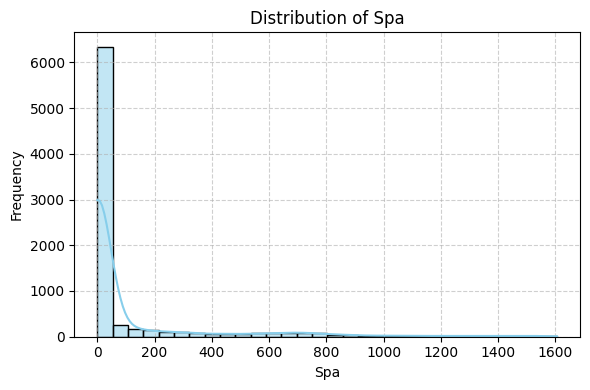

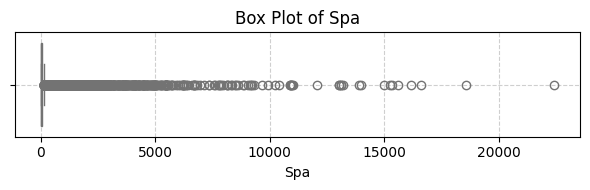

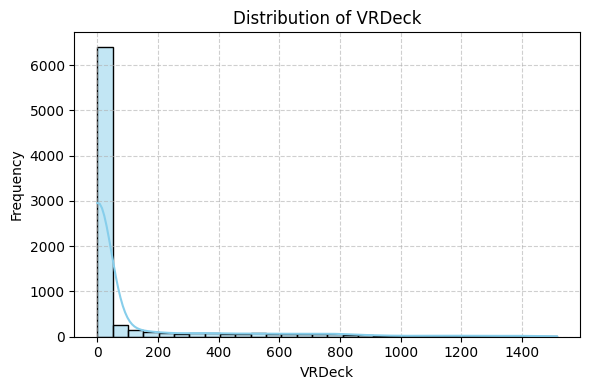

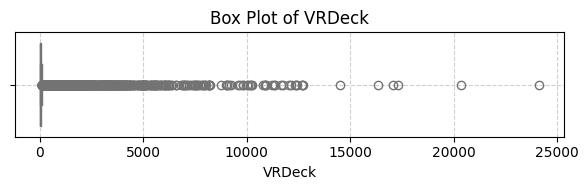

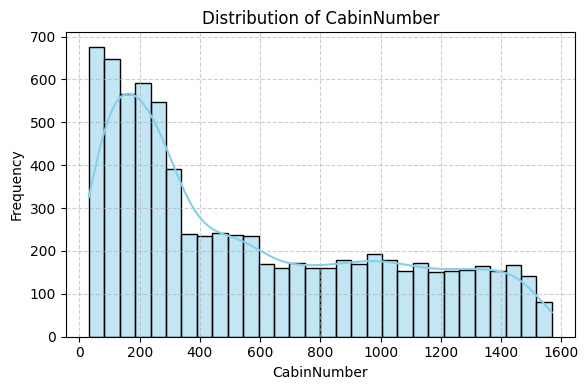

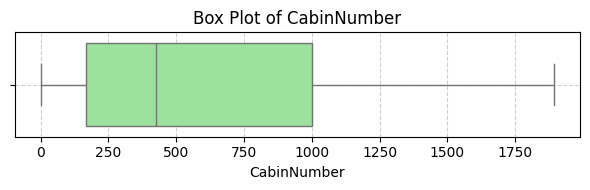

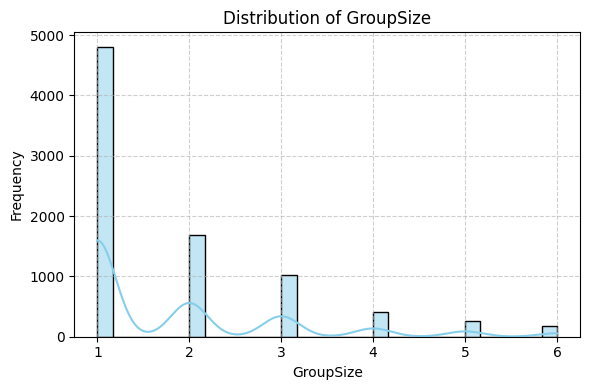

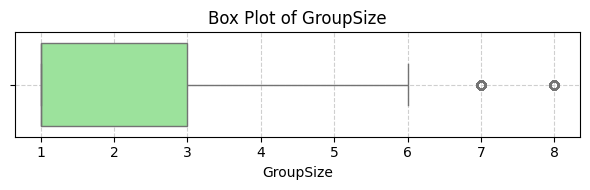


🔹 Categorical column value counts (≤ 20 unique values):
Skipping 'PassengerId' (too many unique values: 8693)


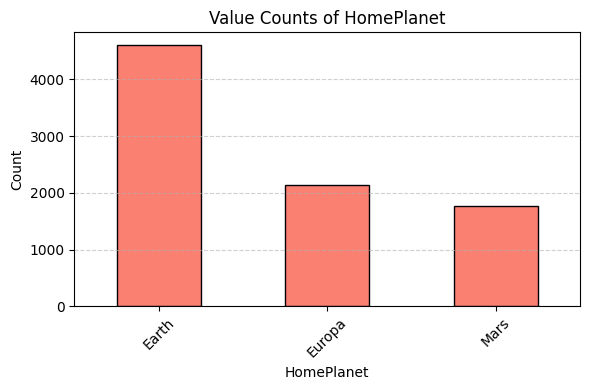

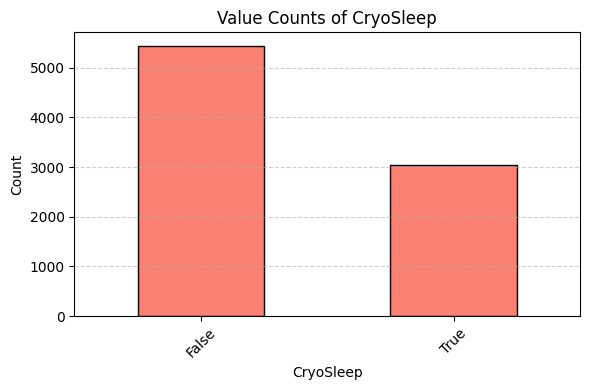

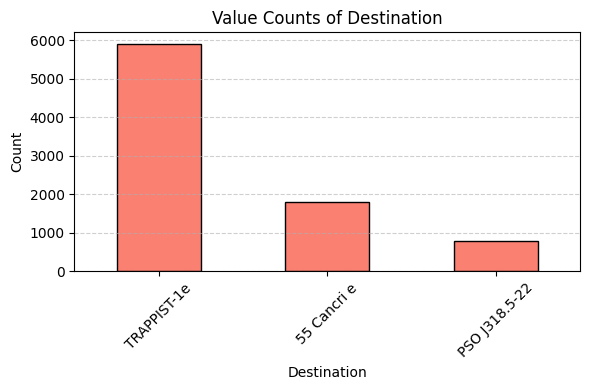

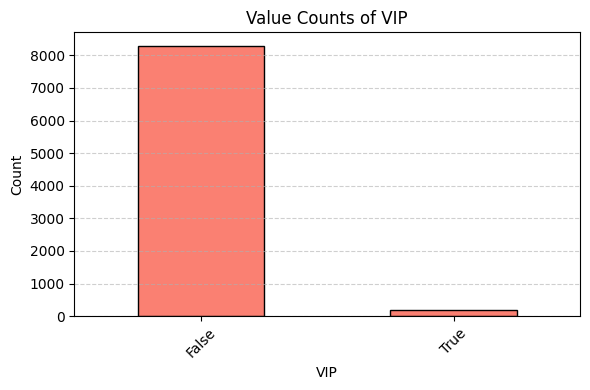

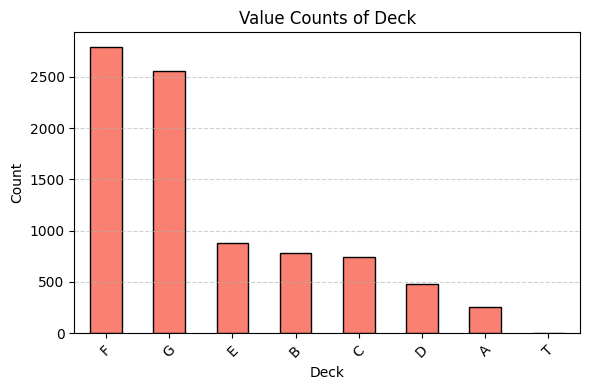

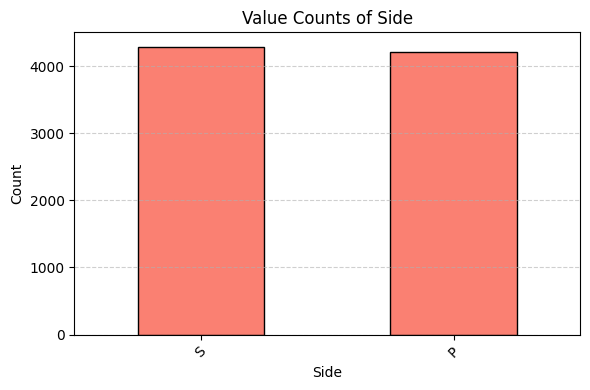

In [ ]:
def basic_eda(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 100)

    print("\n🔹 Correlation heatmap (numerical columns):")
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # 🔹 Distribution plots and box plots for numeric columns
    for col in df.select_dtypes(include='number').columns:
        lower = df[col].quantile(0.05)
        upper = df[col].quantile(0.95)
        filtered_data = df[col][(df[col] >= lower) & (df[col] <= upper)]

        # Histogram
        plt.figure(figsize=(6, 4))
        sns.histplot(filtered_data.dropna(), kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Box plot
        plt.figure(figsize=(6, 2))
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f"Box Plot of {col}")
        plt.xlabel(col)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # 🔹 Bar plots for categorical columns (object or category) with ≤ 20 unique values
    print("\n🔹 Categorical column value counts (≤ 20 unique values):")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique > 20:
            print(f"Skipping '{col}' (too many unique values: {n_unique})")
            continue

        plt.figure(figsize=(6, 4))
        df[col].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
        plt.title(f"Value Counts of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

basic_eda(train_df)


In [ ]:
feature_cols = base_categorical_cols + ['Deck', 'Side', 'GroupSize']

train_encoded = pd.get_dummies(train_df[feature_cols], drop_first=True)
test_encoded  = pd.get_dummies(test_df[feature_cols], drop_first=True)

train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

In [ ]:
print("\n🔹 Catagorial one hot encoding:")
display(train_encoded.head(10))  # Show first 10 rows


🔹 Catagorial one hot encoding:


,GroupSize,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,1,True,False,False,False,True,False,True,False,False,False,False,False,False,False
1,1,False,False,False,False,True,False,False,False,False,False,True,False,False,True
2,2,True,False,False,False,True,True,False,False,False,False,False,False,False,True
3,2,True,False,False,False,True,False,False,False,False,False,False,False,False,True
4,1,False,False,False,False,True,False,False,False,False,False,True,False,False,True
5,1,False,False,False,True,False,False,False,False,False,False,True,False,False,False
6,2,False,False,False,False,True,False,False,False,False,False,True,False,False,True
7,2,False,False,True,False,True,False,False,False,False,False,False,True,False,True
8,1,False,False,False,False,True,False,False,False,False,False,True,False,False,True
9,3,True,False,True,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
missing_df = train_df.isnull().sum().to_frame(name='Missing Values')
missing_df['% Missing'] = (missing_df['Missing Values'] / len(train_df) * 100).round(2)
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
display(missing_df)

,Missing Values,% Missing
CryoSleep,217,2.50
ShoppingMall,208,2.39
VIP,203,2.34
HomePlanet,201,2.31
Side,199,2.29
CabinNumber,199,2.29
Deck,199,2.29
VRDeck,188,2.16
FoodCourt,183,2.11
Spa,183,2.11


In [ ]:
for col in categorical_cols:
    if col in train_df.columns and col in test_df.columns:
        if train_df[col].dtype.name == "category":
            if "Unknown" not in train_df[col].cat.categories:
                train_df[col] = train_df[col].cat.add_categories("Unknown")
                test_df[col] = test_df[col].cat.add_categories("Unknown")
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")


train = train_df.copy()
test = test_df.copy()

numeric_cols = train.select_dtypes(include='number').columns.tolist()
categorical_cols = train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_cols.remove('Transported')


train[categorical_cols] = train[categorical_cols].astype(str)
test[categorical_cols] = test[categorical_cols].astype(str)

In [ ]:
def simulate_numeric_missing(df, cols, frac=0.1):
    np.random.seed(42)
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    masked_df = df.copy()
    for col in cols:
        missing_indices = np.random.rand(len(df)) < frac
        masked_df.loc[missing_indices, col] = np.nan
        mask.loc[missing_indices, col] = True
    return masked_df, mask

original_test = test.copy()
masked_test, missing_mask = simulate_numeric_missing(test, numeric_cols)

In [ ]:
simple_imputer = SimpleImputer(strategy='median')
simple_imputer.fit(train[numeric_cols])
simple_numeric = pd.DataFrame(simple_imputer.transform(masked_test[numeric_cols]), columns=numeric_cols)

knn_imputer = KNNImputer(n_neighbors=7)
knn_imputer.fit(train[numeric_cols])
knn_numeric = pd.DataFrame(knn_imputer.transform(masked_test[numeric_cols]), columns=numeric_cols)

iter_imputer = IterativeImputer(random_state=42, max_iter=10)
iter_imputer.fit(train[numeric_cols])
iter_numeric = pd.DataFrame(iter_imputer.transform(masked_test[numeric_cols]), columns=numeric_cols)

In [ ]:
def masked_rmse(true_df, imputed_df, mask):
    diff = true_df[mask] - imputed_df[mask]
    mse = np.nanmean(diff ** 2)
    return np.sqrt(mse)

results = {
    "Simple Imputer": masked_rmse(original_test[numeric_cols], simple_numeric, missing_mask[numeric_cols]),
    "KNN Imputer": masked_rmse(original_test[numeric_cols], knn_numeric, missing_mask[numeric_cols]),
    "Iterative Imputer": masked_rmse(original_test[numeric_cols], iter_numeric, missing_mask[numeric_cols]),
}

print("RMSE Comparison:")
for method, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"🔹 {method:<20} | RMSE = {score:.4f}")


RMSE Comparison:
🔹 Iterative Imputer    | RMSE = 906.4431
🔹 KNN Imputer          | RMSE = 930.2897
🔹 Simple Imputer       | RMSE = 966.1883


In [ ]:
from IPython.display import display
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def imputation_difference_rmse(imputed_1, imputed_2, mask):
    diffs = []
    for col in imputed_1.columns:
        # Make sure all Series have the same index
        common_index = imputed_1.index.intersection(imputed_2.index).intersection(mask.index)

        # Extract values and mask for that column
        col_mask = mask.loc[common_index, col]

        # Skip if mask is all False or contains NA
        if col_mask.sum() == 0 or col_mask.isnull().all():
            continue

        vals_1 = imputed_1.loc[common_index, col][col_mask]
        vals_2 = imputed_2.loc[common_index, col][col_mask]

        rmse = root_mean_squared_error(vals_1, vals_2)
        diffs.append((col, rmse))

    df = pd.DataFrame(diffs, columns=['Column', 'RMSE']).sort_values('RMSE', ascending=False)
    return df

# Your comparisons
print("🔹 Simple vs KNN")
display(imputation_difference_rmse(simple_numeric, knn_numeric, missing_mask))

print("\n🔹 Simple vs Iterative")
display(imputation_difference_rmse(simple_numeric, iter_numeric, missing_mask))

print("\n🔹 KNN vs Iterative")
display(imputation_difference_rmse(knn_numeric, iter_numeric, missing_mask))


🔹 Simple vs KNN


,Column,RMSE
2,FoodCourt,519.205038
5,VRDeck,423.901583
1,RoomService,341.766261
4,Spa,341.643403
6,CabinNumber,271.885414
3,ShoppingMall,247.958817
0,Age,6.315152
7,GroupSize,1.359697



🔹 Simple vs Iterative


,Column,RMSE
2,FoodCourt,626.076970
4,Spa,450.833546
5,VRDeck,399.285215
1,RoomService,226.331409
6,CabinNumber,220.269994
3,ShoppingMall,174.452697
0,Age,3.759102
7,GroupSize,1.066903



🔹 KNN vs Iterative


,Column,RMSE
2,FoodCourt,564.016284
4,Spa,440.706669
5,VRDeck,397.662094
1,RoomService,302.123909
6,CabinNumber,245.604056
3,ShoppingMall,215.324099
0,Age,6.042718
7,GroupSize,0.759520


In [ ]:
# Filter train rows with known target
train_df_clean = train_df.dropna(subset=['Transported'])
y = train_df_clean['Transported'].astype(bool)

# Define numeric columns again (in case you dropped rows)
numeric_cols = train_df_clean.select_dtypes(include='number').columns.tolist()
cat_cols = base_categorical_cols + ['Deck', 'Side', 'GroupSize']
categorical_df = train_df_clean[cat_cols].reset_index(drop=True)


# Fit imputers on train_df_clean
simple_imputer = SimpleImputer(strategy='median')
simple_imputer.fit(train_df_clean[numeric_cols])
simple_numeric = pd.DataFrame(simple_imputer.transform(train_df_clean[numeric_cols]), columns=numeric_cols)

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer.fit(train_df_clean[numeric_cols])
knn_numeric = pd.DataFrame(knn_imputer.transform(train_df_clean[numeric_cols]), columns=numeric_cols)

iter_imputer = IterativeImputer(max_iter=10, random_state=42)
iter_imputer.fit(train_df_clean[numeric_cols])
iter_numeric = pd.DataFrame(iter_imputer.transform(train_df_clean[numeric_cols]), columns=numeric_cols)


simple_test_numeric = pd.DataFrame(
    simple_imputer.transform(test_df[numeric_cols]),
    columns=numeric_cols
)

knn_test_numeric = pd.DataFrame(
    knn_imputer.transform(test_df[numeric_cols]),
    columns=numeric_cols
)

iter_test_numeric = pd.DataFrame(
    iter_imputer.transform(test_df[numeric_cols]),
    columns=numeric_cols
)

In [ ]:
# Step 1: Create _missing columns for both train and test
train_clean_with_flags = train_df_clean.copy()
test_with_flags = test_df.copy()

for col in numeric_cols:
    train_clean_with_flags[f'{col}_missing'] = train_clean_with_flags[col].isna().astype(int)
    test_with_flags[f'{col}_missing'] = test_with_flags[col].isna().astype(int)

missing_flag_cols = [f'{col}_missing' for col in numeric_cols]

# Step 2: Function for imputation + flags
def apply_imputer_with_flags(imputer, df, numeric_cols, missing_flag_cols):
    imputed_numeric = pd.DataFrame(imputer.transform(df[numeric_cols]), columns=numeric_cols)
    return pd.concat([imputed_numeric.reset_index(drop=True), df[missing_flag_cols].reset_index(drop=True)], axis=1)

# Step 3: Imputation for train set
simple_numeric_flags = apply_imputer_with_flags(simple_imputer, train_clean_with_flags, numeric_cols, missing_flag_cols)
knn_numeric_flags    = apply_imputer_with_flags(knn_imputer,    train_clean_with_flags, numeric_cols, missing_flag_cols)
iter_numeric_flags   = apply_imputer_with_flags(iter_imputer,   train_clean_with_flags, numeric_cols, missing_flag_cols)

display(simple_numeric_flags.head(10))

# Imputation for test set
simple_test_numeric_flags = apply_imputer_with_flags(simple_imputer, test_with_flags, numeric_cols, missing_flag_cols)
knn_test_numeric_flags    = apply_imputer_with_flags(knn_imputer,    test_with_flags, numeric_cols, missing_flag_cols)
iter_test_numeric_flags   = apply_imputer_with_flags(iter_imputer,   test_with_flags, numeric_cols, missing_flag_cols)

# Step 4: Combine with original (not encoded) categorical columns
cat_cols = base_categorical_cols + ['Deck', 'Side', 'GroupSize']
categorical_df_train = train_clean_with_flags[cat_cols].reset_index(drop=True)
categorical_df_test  = test_with_flags[cat_cols].reset_index(drop=True)

# Combine train sets
X_train_simple_flags = pd.concat([simple_numeric_flags.reset_index(drop=True), categorical_df_train], axis=1)
X_train_knn_flags    = pd.concat([knn_numeric_flags.reset_index(drop=True),    categorical_df_train], axis=1)
X_train_iter_flags   = pd.concat([iter_numeric_flags.reset_index(drop=True),   categorical_df_train], axis=1)

# Combine test sets
X_test_simple_flags = pd.concat([simple_test_numeric_flags.reset_index(drop=True), categorical_df_test], axis=1)
X_test_knn_flags    = pd.concat([knn_test_numeric_flags.reset_index(drop=True),    categorical_df_test], axis=1)
X_test_iter_flags   = pd.concat([iter_test_numeric_flags.reset_index(drop=True),   categorical_df_test], axis=1)



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,GroupSize,Age_missing,RoomService_missing,FoodCourt_missing,ShoppingMall_missing,Spa_missing,VRDeck_missing,CabinNumber_missing,GroupSize_missing
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,1.0,0,0,0,0,0,0,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,2.0,0,0,0,0,0,0,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,2.0,0,0,0,0,0,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0
5,44.0,0.0,483.0,0.0,291.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0
6,26.0,42.0,1539.0,3.0,0.0,0.0,2.0,2.0,0,0,0,0,0,0,0,0
7,28.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,1,0,0
8,35.0,0.0,785.0,17.0,216.0,0.0,3.0,1.0,0,0,0,0,0,0,0,0
9,14.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0


In [ ]:
def add_interaction_features_only(X):
    X = X.copy()

    # Drop duplicate columns, keeping the first occurrence
    X = X.loc[:, ~X.columns.duplicated()]

    for col in X.columns:
        if col.endswith("_missing"):
            base_col = col.replace("_missing", "")
            if base_col in X.columns:
                interaction_col = f"{base_col}_interaction"
                X[interaction_col] = X[base_col] * (1 - X[col])
    return X



X_train_simple_interactions = add_interaction_features_only(X_train_simple_flags)
X_train_knn_interactions    = add_interaction_features_only(X_train_knn_flags)
X_train_iter_interactions   = add_interaction_features_only(X_train_iter_flags)

X_test_simple_interactions  = add_interaction_features_only(X_test_simple_flags)
X_test_knn_interactions     = add_interaction_features_only(X_test_knn_flags)
X_test_iter_interactions    = add_interaction_features_only(X_test_iter_flags)




In [ ]:
# Step 1: One-Hot Encoding for Categorical Features
cat_cols = base_categorical_cols + ['Deck', 'Side', 'GroupSize']

# Convert categorical columns to one-hot (drop_first=True to avoid multicollinearity)
train_encoded = pd.get_dummies(train_df_clean[cat_cols], drop_first=True)
test_encoded  = pd.get_dummies(test_df[cat_cols], drop_first=True)

# Align test columns to match training columns (fill missing ones with 0)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

# Step 2: Combine numeric and encoded categorical features
def combine_features(numeric_df, encoded_df):
    return pd.concat([numeric_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Step 3: Create feature matrices (with and without missing flags)
X_train_simple       = combine_features(simple_numeric, train_encoded)
X_train_knn          = combine_features(knn_numeric, train_encoded)
X_train_iter         = combine_features(iter_numeric, train_encoded)

X_train_simple_flags = combine_features(simple_numeric_flags, train_encoded)
X_train_knn_flags    = combine_features(knn_numeric_flags, train_encoded)
X_train_iter_flags   = combine_features(iter_numeric_flags, train_encoded)

# Combine numeric interaction features with encoded categorical features
X_train_simple_interact = combine_features(X_train_simple_interactions, train_encoded)
X_train_knn_interact    = combine_features(X_train_knn_interactions,    train_encoded)
X_train_iter_interact   = combine_features(X_train_iter_interactions,   train_encoded)


test_encoded = pd.get_dummies(test_df[cat_cols], drop_first=True)

# Step 2: Align test columns to match training one-hot encoded columns
# (Assumes train_encoded already exists from previous step)
_, test_encoded_aligned = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

# Step 3: Combine numeric and encoded categorical features for test sets
X_test_simple        = combine_features(simple_test_numeric, test_encoded_aligned)
X_test_knn           = combine_features(knn_test_numeric,    test_encoded_aligned)
X_test_iter          = combine_features(iter_test_numeric,   test_encoded_aligned)

X_test_simple_flags  = combine_features(simple_test_numeric_flags, test_encoded_aligned)
X_test_knn_flags     = combine_features(knn_test_numeric_flags,    test_encoded_aligned)
X_test_iter_flags    = combine_features(iter_test_numeric_flags,   test_encoded_aligned)

X_test_simple_interact  = combine_features(X_test_simple_interactions,  test_encoded_aligned)
X_test_knn_interact     = combine_features(X_test_knn_interactions,     test_encoded_aligned)
X_test_iter_interact    = combine_features(X_test_iter_interactions,    test_encoded_aligned)


##ML##

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': [6]
}

# Define your datasets
datasets = {
    "Simple": X_train_simple,
    "KNN": X_train_knn,
    "Iterative": X_train_iter,
    "Simple + Flags": X_train_simple_flags,
    "KNN + Flags": X_train_knn_flags,
    "Iterative + Flags": X_train_iter_flags,
    "Simple + Interaction": X_train_simple_interact,
    "KNN + Interaction": X_train_knn_interact,
    "Iterative + Interaction": X_train_iter_interact
}

# Function to encode categorical variables
def encode_dataset(X):
    return pd.get_dummies(X, drop_first=True)

# Dictionary to store best results
best_scores = {}

print("\nModel Performance Comparison:\n")

# Loop over datasets
for name, X in datasets.items():
    try:
        X_encoded = encode_dataset(X)

        grid = GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )

        grid.fit(X_encoded, y)

        best_scores[name] = {
            "score": grid.best_score_,
            "params": grid.best_params_
        }

        print(f"{name} - Accuracy: {grid.best_score_:.4f} | Best Params: {grid.best_params_}")

    except Exception as e:
        print(f"{name} - Failed due to error: {e}")

# Optionally, display best scores sorted
print("\nTop Models:")
for name, result in sorted(best_scores.items(), key=lambda x: x[1]['score'], reverse=True):
    print(f"{name}: {result['score']:.4f}")



Model Performance Comparison:

Simple - Accuracy: 0.7958 | Best Params: {'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
KNN - Accuracy: 0.7983 | Best Params: {'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Iterative - Accuracy: 0.7988 | Best Params: {'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Simple + Flags - Accuracy: 0.7978 | Best Params: {'max_depth': 30, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
KNN + Flags - Accuracy: 0.7969 | Best Params: {'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Iterative + Flags - Accuracy: 0.8003 | Best Params: {'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Simple + Interaction - Accuracy: 0.7992 | Best Params: {'max_depth':

In [ ]:
import pandas as pd

# Extract results into a summary table
summary_data = []

for name, result in best_scores.items():
    row = {
        "Dataset": name,
        "Accuracy": result["score"],
        "n_estimators": result["params"]["n_estimators"],
        "max_depth": result["params"]["max_depth"],
        "min_samples_split": result["params"]["min_samples_split"],
        "min_samples_leaf": result["params"]["min_samples_leaf"],
        "max_features": result["params"]["max_features"]
    }
    summary_data.append(row)

summary = pd.DataFrame(summary_data)
display(summary)




,Dataset,Accuracy,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,Simple,0.795817,200,20,5,2,6
1,KNN,0.798347,100,10,5,2,6
2,Iterative,0.798807,100,10,5,2,6
3,Simple + Flags,0.797773,300,30,5,2,6
4,KNN + Flags,0.796851,200,10,5,2,6
5,Iterative + Flags,0.800303,100,20,5,2,6
6,Simple + Interaction,0.799153,100,20,5,2,6
7,KNN + Interaction,0.797772,300,10,5,2,6
8,Iterative + Interaction,0.798346,200,10,5,2,6


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Convert bools to ints
X_train_iter_flags = X_train_iter_flags.astype({col: 'int' for col in X_train_iter_flags.select_dtypes('bool').columns})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_train_iter_flags, y, test_size=0.2, random_state=42)

# Flatten label arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print(f"XGBoost Accuracy: {accuracy:.5f}")


/tmp/ipython-input-26-705681688.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()
/tmp/ipython-input-26-705681688.py:13: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:49:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.80736


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split training into train/validation for early stopping
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_final, label=y_train_final)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Params from your previous best model
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.1,
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dval, 'eval')]

# Train with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=True
)

# Evaluate on test set
preds = bst.predict(dtest)
final_preds = [1 if p > 0.5 else 0 for p in preds]
accuracy = accuracy_score(y_test, final_preds)
print(f"Final Accuracy with Early Stopping: {accuracy:.5f}")


[0]	train-logloss:0.65402	eval-logloss:0.65554
[1]	train-logloss:0.62195	eval-logloss:0.62511
[2]	train-logloss:0.59274	eval-logloss:0.59667
[3]	train-logloss:0.56881	eval-logloss:0.57391
[4]	train-logloss:0.54975	eval-logloss:0.55818
[5]	train-logloss:0.53006	eval-logloss:0.54054
[6]	train-logloss:0.51302	eval-logloss:0.52511
[7]	train-logloss:0.49808	eval-logloss:0.51298
[8]	train-logloss:0.48464	eval-logloss:0.50227
[9]	train-logloss:0.47190	eval-logloss:0.49145
[10]	train-logloss:0.46205	eval-logloss:0.48356
[11]	train-logloss:0.45211	eval-logloss:0.47620
[12]	train-logloss:0.44295	eval-logloss:0.46892
[13]	train-logloss:0.43538	eval-logloss:0.46259
[14]	train-logloss:0.42775	eval-logloss:0.45644
[15]	train-logloss:0.41923	eval-logloss:0.45089
[16]	train-logloss:0.41165	eval-logloss:0.44523
[17]	train-logloss:0.40653	eval-logloss:0.44075
[18]	train-logloss:0.40202	eval-logloss:0.43718
[19]	train-logloss:0.39668	eval-logloss:0.43394
[20]	train-logloss:0.39162	eval-logloss:0.42977
[2

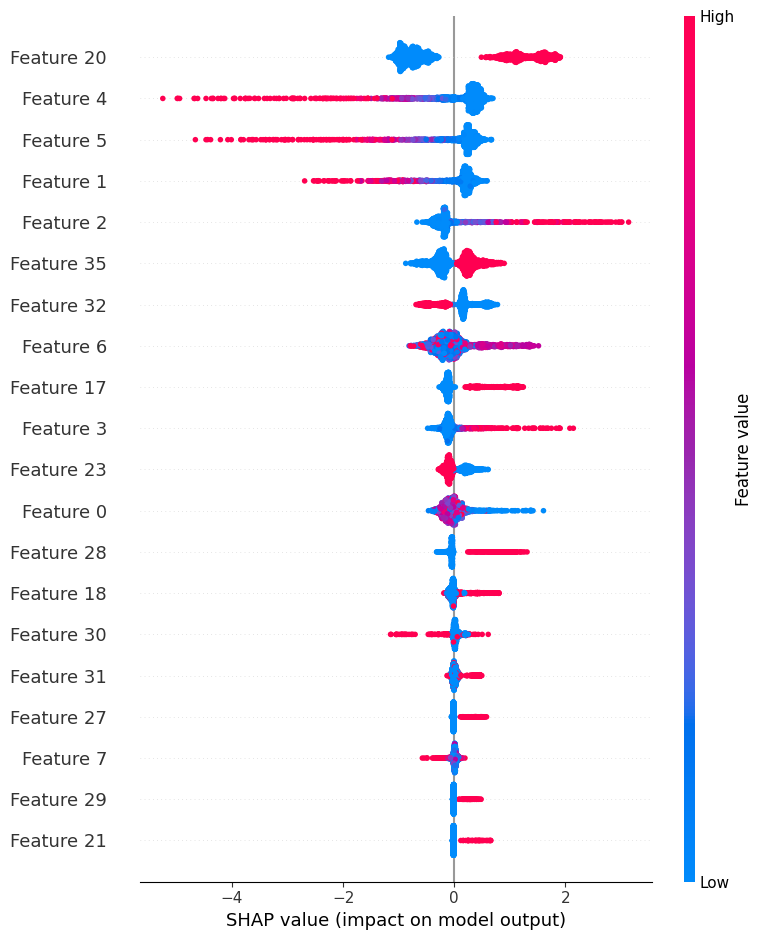

In [ ]:
import shap

# Create SHAP explainer from the XGBoost booster
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Summary plot (most important features overall)
shap.summary_plot(shap_values, X_test)


Classification Report:

              precision    recall  f1-score   support

       False       0.79      0.81      0.80       861
        True       0.81      0.79      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



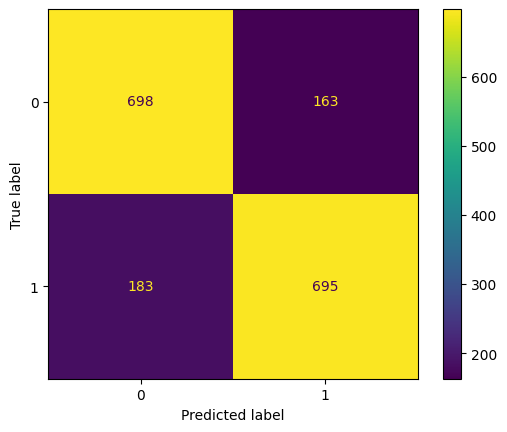

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report:\n")
print(classification_report(y_test, final_preds))

# Confusion matrix plot
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


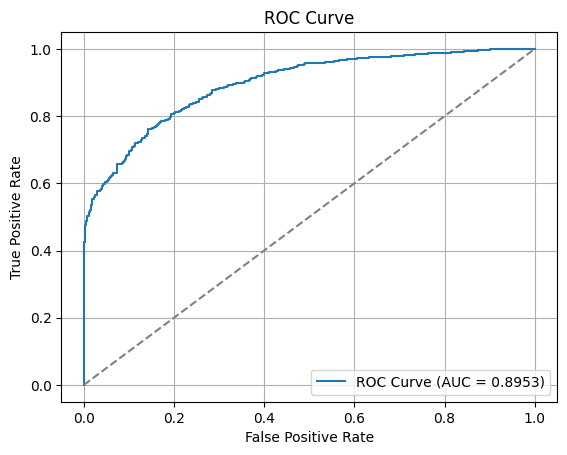

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

probs = bst.predict(dtest)  # Get predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = roc_auc_score(y_test, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import xgboost as xgb

# Save the original PassengerId before any transformation
passenger_ids = test_df['PassengerId'].astype(str).values  # Assumes you have X_test_raw!

# Convert bools to int (for xgboost)
X_test_iter_flags = X_test_iter.astype({col: 'int' for col in X_test_iter.select_dtypes('bool').columns})

# Prepare DMatrix
dtest_iter_flags = xgb.DMatrix(X_test_iter_flags.values)

# Predict probabilities
probs = bst.predict(dtest_iter_flags)

# Predict binary class
preds = (probs > 0.5)

# Build final DataFrame
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': preds.astype(bool)
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("✅ Predictions saved to submission.csv")


✅ Predictions saved to submission.csv


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Ensure proper DataFrame format
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Optional: assign generic column names if not set
X_train.columns = [f'Feature {i}' for i in range(X_train.shape[1])]
X_test.columns = X_train.columns  # match

# Convert all object columns to categorical → numeric
for df in [X_train, X_test]:
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category').cat.codes

# Your SHAP-based feature importance (edit as needed)
feature_ranking = [
    'Feature 12', 'Feature 4', 'Feature 5', 'Feature 1', 'Feature 24',
    'Feature 2', 'Feature 27', 'Feature 6', 'Feature 9', 'Feature 3',
    'Feature 15', 'Feature 0', 'Feature 20', 'Feature 10', 'Feature 23',
    'Feature 22', 'Feature 7', 'Feature 19', 'Feature 13', 'Feature 21'
]

print("📊 Trying different feature subsets...\n")
accuracies = []

for k in range(0, 15):  # Try removing 0 to 14 least important features
    drop_features = feature_ranking[-k:] if k > 0 else []

    X_train_k = X_train.drop(columns=drop_features)
    X_test_k = X_test.drop(columns=drop_features)

    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train_k, y_train, test_size=0.2, random_state=42
    )

    dtrain = xgb.DMatrix(X_train_final, label=y_train_final)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test_k)

    params = {
        'objective': 'binary:logistic',
        'max_depth': 6,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda': 1.0,
        'alpha': 0.1,
        'eval_metric': 'logloss'
    }

    evals = [(dtrain, 'train'), (dval, 'eval')]

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=30,
        verbose_eval=False
    )

    preds = bst.predict(dtest)
    final_preds = (preds > 0.5).astype(int)
    acc = accuracy_score(y_test, final_preds)

    print(f"Removed {k} features → Accuracy: {acc:.5f}")
    accuracies.append((k, acc))

print("\n✅ Done.")


📊 Trying different feature subsets...

Removed 0 features → Accuracy: 0.80104
Removed 1 features → Accuracy: 0.79816
Removed 2 features → Accuracy: 0.81024
Removed 3 features → Accuracy: 0.79873
Removed 4 features → Accuracy: 0.81139
Removed 5 features → Accuracy: 0.81254
Removed 6 features → Accuracy: 0.80736
Removed 7 features → Accuracy: 0.80449
Removed 8 features → Accuracy: 0.79643
Removed 9 features → Accuracy: 0.79011
Removed 10 features → Accuracy: 0.80161
Removed 11 features → Accuracy: 0.79356
Removed 12 features → Accuracy: 0.79356
Removed 13 features → Accuracy: 0.78551
Removed 14 features → Accuracy: 0.78666

✅ Done.


In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Example best parameters — change to your real best values
best_xgb = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'reg_alpha': 0.0
}

# 1. Drop PassengerId from test set
X_test_full = test_df.drop(columns=["PassengerId"]).copy()

# 2. Encode object columns to categorical codes (like you did in training)
for col in X_test_full.select_dtypes(include='object').columns:
    X_test_full[col] = X_test_full[col].astype('category').cat.codes

# 3. Add any missing columns to test set and fill with 0
for col in X_train.columns:
    if col not in X_test_full.columns:
        X_test_full[col] = 0

# 4. Remove any extra columns in test not in train
X_test_full = X_test_full[X_train.columns]

# 5. Compute least important features from a quick XGBoost model
temp_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
temp_model.fit(X_train, y_train)

importances = temp_model.feature_importances_
least_important_features = list(
    pd.Series(importances, index=X_train.columns)
    .sort_values()
    .head(10)  # You can change this number
    .index
)

# 6. Drop least important features
X_train_reduced = X_train.drop(columns=least_important_features)
X_test_reduced = X_test_full.drop(columns=least_important_features)

# 7. Train final model using best_xgb hyperparameters
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)
dtest = xgb.DMatrix(X_test_reduced)

params = {
    'objective': 'binary:logistic',
    'max_depth': best_xgb['max_depth'],
    'eta': best_xgb['learning_rate'],
    'subsample': best_xgb['subsample'],
    'colsample_bytree': best_xgb['colsample_bytree'],
    'lambda': best_xgb['reg_lambda'],
    'alpha': best_xgb['reg_alpha'],
    'eval_metric': 'logloss'
}

bst_final = xgb.train(
    params,
    dtrain,
    num_boost_round=best_xgb['n_estimators']
)

# 8. Predict
probs = bst_final.predict(dtest)
preds = (probs > 0.5)

# 9. Submission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].astype(str),
    'Transported': preds.astype(bool)
})

assert len(submission) == 4277, "❌ Submission does not have 4277 rows!"
submission.to_csv("submission.csv", index=False)
print("✅ Submission saved with 4277 rows.")


✅ Submission saved with 4277 rows.


**************************************


🔄 Training and predicting for: Simple

🔄 Training and predicting for: KNN

🔄 Training and predicting for: Iterative

🔄 Training and predicting for: Simple + Flags

🔄 Training and predicting for: KNN + Flags

🔄 Training and predicting for: Iterative + Flags


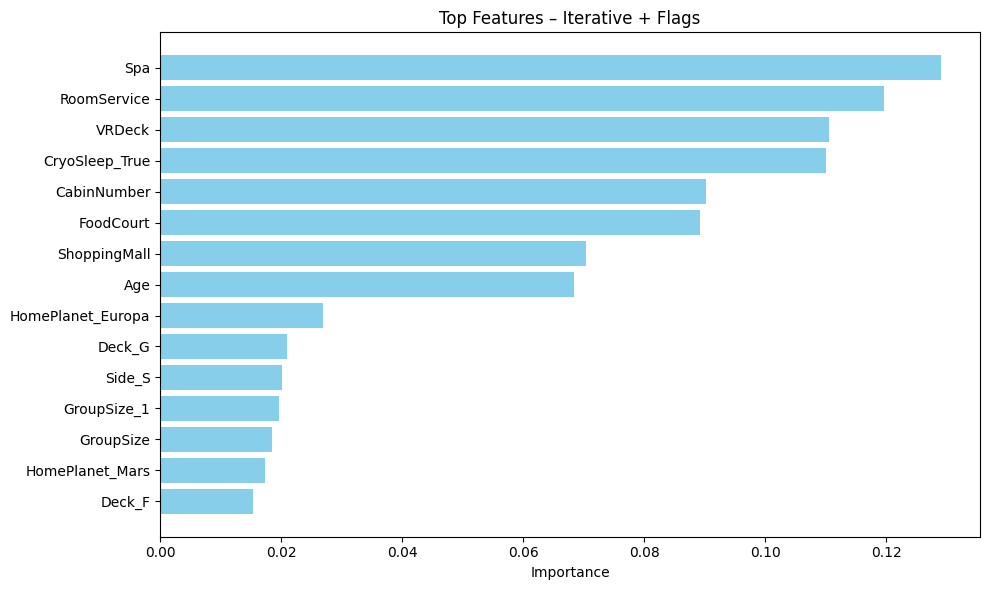

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Helper: make all column names in a DataFrame unique
def ensure_unique_columns(df: pd.DataFrame):
    seen = {}
    new_cols = []
    for col in df.columns:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
    df.columns = new_cols

# 1. Your raw train/test dicts
train_sets = {
    "Simple": X_train_simple,
    "KNN": X_train_knn,
    "Iterative": X_train_iter,
    "Simple + Flags": X_train_simple_flags,
    "KNN + Flags": X_train_knn_flags,
    "Iterative + Flags": X_train_iter_flags
}
test_sets = {
    "Simple": X_test_simple,
    "KNN": X_test_knn,
    "Iterative": X_test_iter,
    "Simple + Flags": X_test_simple_flags,
    "KNN + Flags": X_test_knn_flags,
    "Iterative + Flags": X_test_iter_flags
}

# 2. Ensure unique columns in each dataset
for name in train_sets:
    ensure_unique_columns(train_sets[name])
    ensure_unique_columns(test_sets[name])

# 3. Helper to align test → train
def align_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> pd.DataFrame:
    # reindex adds missing cols (fill 0), drops extras, enforces order
    X = X_test.reindex(columns=X_train.columns, fill_value=0)
    # match dtypes exactly
    return X.astype(X_train.dtypes.to_dict())

# 4. Containers for models & predictions
final_test_predictions = {}
trained_models = {}

# 5. Train & Predict loop
for name, X_train in train_sets.items():
    print(f"\n🔄 Training and predicting for: {name}")

    X_test = test_sets[name]
    best_params = best_scores[name]["params"]

    # Train
    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train, y)
    trained_models[name] = model

    # Align and predict
    X_test_aligned = align_features(X_train, X_test)
    preds = model.predict(X_test_aligned)
    final_test_predictions[name] = preds

# 6. (Optional) Feature importance helpers
def show_top_features(model, X_train, top_n=15):
    imps = model.feature_importances_
    idx = imps.argsort()[::-1][:top_n]
    return pd.DataFrame({
        "Feature": X_train.columns[idx],
        "Importance": imps[idx]
    })

def plot_feature_importance(df, title="Top Features"):
    plt.figure(figsize=(10,6))
    plt.barh(df["Feature"], df["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Example plot
top_feats = show_top_features(trained_models["Iterative + Flags"], train_sets["Iterative + Flags"])
plot_feature_importance(top_feats, "Top Features – Iterative + Flags")


In [ ]:
# Replace with your actual ID column in test_df
id_column = test_df['PassengerId']

# Save each model's predictions to a separate CSV
for name, preds in final_test_predictions.items():
    submission_df = pd.DataFrame({
        'PassengerId': id_column,
        'Transported': preds.astype(bool)  # Ensure boolean format
    })

    # Clean file name for saving
    filename = f"submission_{name.replace(' ', '_').replace('+', 'plus')}.csv"

    # Save to CSV
    submission_df.to_csv(filename, index=False)


In [ ]:
import pandas as pd

# Extract results into a summary table
summary_data = []

for name, result in best_scores.items():
    row = {
        "Dataset": name,
        "Accuracy": result["score"],
        "n_estimators": result["params"]["n_estimators"],
        "max_depth": result["params"]["max_depth"],
        "min_samples_split": result["params"]["min_samples_split"],
        "min_samples_leaf": result["params"]["min_samples_leaf"],
        "max_features": result["params"]["max_features"]
    }
    summary_data.append(row)

summary = pd.DataFrame(summary_data)
display(summary.sort_values('Accuracy', ascending=False))

,Dataset,Accuracy,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
5,Iterative + Flags,0.800303,100,20,5,2,6
6,Simple + Interaction,0.799153,100,20,5,2,6
2,Iterative,0.798807,100,10,5,2,6
1,KNN,0.798347,100,10,5,2,6
8,Iterative + Interaction,0.798346,200,10,5,2,6
3,Simple + Flags,0.797773,300,30,5,2,6
7,KNN + Interaction,0.797772,300,10,5,2,6
4,KNN + Flags,0.796851,200,10,5,2,6
0,Simple,0.795817,200,20,5,2,6


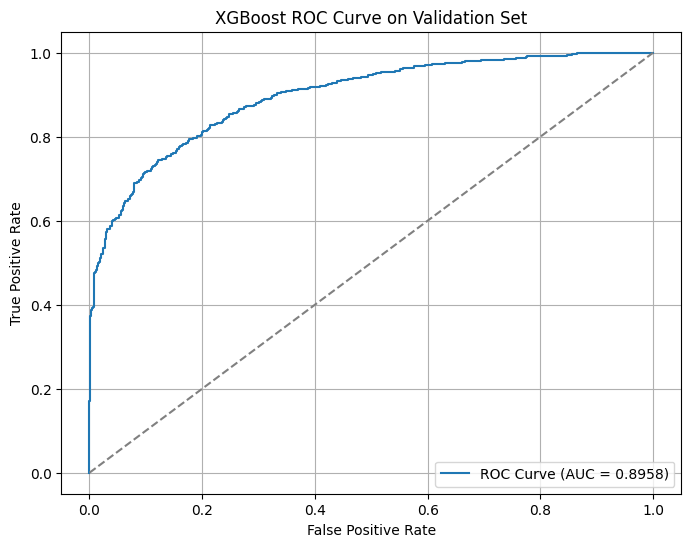

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Split your reduced training data into train + validation
#    (Assumes X_train_reduced, y_train are already defined)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_reduced, y_train, test_size=0.2, random_state=42
)

# 2. Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)

# 3. Define your parameters (use your best_xgb dict here)
params = {
    'objective': 'binary:logistic',
    'max_depth': best_xgb['max_depth'],
    'eta': best_xgb['learning_rate'],
    'subsample': best_xgb['subsample'],
    'colsample_bytree': best_xgb['colsample_bytree'],
    'lambda': best_xgb['reg_lambda'],
    'alpha': best_xgb['reg_alpha'],
    'eval_metric': 'logloss'
}

# 4. Train the model
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=best_xgb['n_estimators'],
    evals=[(dvalid, "validation")],
    verbose_eval=False
)

# 5. Predict probabilities on the validation set
probs = bst.predict(dvalid)

# 6. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, probs)
auc_score = roc_auc_score(y_val, probs)

# 7. Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve on Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import xgboost as xgb

# 1. Grab PassengerId for the submission
passenger_ids = test_df['PassengerId'].astype(str)

# 2. Prepare your test DataFrame (Iterative + Flags variant)
X_test = X_test_iter_flags.copy()

# 2a. Convert any boolean columns to integer
bool_cols = X_test.select_dtypes('bool').columns
X_test[bool_cols] = X_test[bool_cols].astype(int)

# 3. Align test set to the exact columns of X_train_reduced
#    (fill missing with 0, drop extras, and enforce train's order)
X_test = X_test.reindex(columns=X_train_reduced.columns, fill_value=0)

# 3a. Match dtypes exactly
X_test = X_test.astype(X_train_reduced.dtypes.to_dict())

# 4. Build the DMatrix from the aligned DataFrame
dtest = xgb.DMatrix(X_test)

# 5. Predict probabilities and then threshold at 0.5
probs = bst_final.predict(dtest)    # bst_final trained on X_train_reduced
preds = (probs > 0.5)

# 6. Create the submission DataFrame and save
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': preds
})
submission.to_csv("submission.csv", index=False)
print(f"✅ submission.csv saved with {len(submission)} rows")


✅ submission.csv saved with 4277 rows
